# Mushroom Dataset Distribution and Cleaning

## Raw Dataset Distribution

In [6]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import torch

In [23]:
# get data about classes from each of the labels
test_label_path = "../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/test/labels/*"
valid_label_path = "../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/valid/labels/*"
train_label_path = "../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/*"
class_labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13']

### Finding Distribution on Classes as it Pertains to Total Instances

In [24]:
def load_data_for_count(file_path, label_list):
    count = 0
    data_output = []
    for item in glob.glob(file_path):
        file_name = os.path.basename(item)
        folder_path = file_path.strip('*')
        file_location = folder_path + file_name
        file_data = open(file_location, "r")
        for line in file_data:
            line.split()
            data = line.split(' ')
            mush_class = data[0]
            data_output.append(mush_class)
    return np.array(data_output)

In [25]:
def count_dict(array, to_dict):
    for item in array:
        if item in to_dict:
            to_dict[item] += 1
        else:
            to_dict[item] = 1
    return to_dict


In [26]:
test_class_labels=load_data_for_count(test_label_path, class_labels)
val_class_labels=load_data_for_count(valid_label_path, class_labels)
train_class_labels=load_data_for_count(train_label_path, class_labels)

In [28]:
class_dict = {}
class_dict = count_dict(test_class_labels, class_dict)
class_dict = count_dict(val_class_labels, class_dict)
class_dict = count_dict(train_class_labels, class_dict)

In [29]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

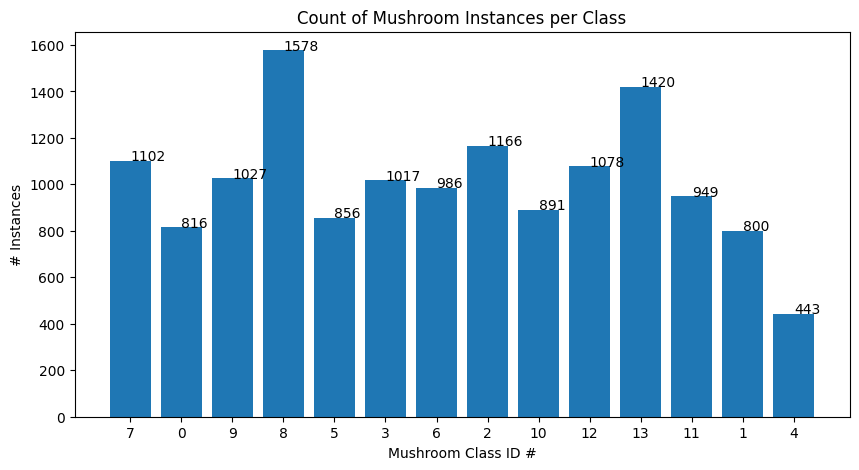

In [30]:
mushroom_class = list(class_dict.keys())
sample_count = list(class_dict.values())

fig = plt.figure(figsize=(10, 5))
plt.bar(mushroom_class, sample_count)
addlabels(mushroom_class, sample_count)
plt.xlabel("Mushroom Class ID #")
plt.ylabel("# Instances")
plt.title("Count of Mushroom Instances per Class")
plt.show()

### Finding Number Distribution on Classes

In [31]:
#for finding number of files per class (only for one instance)
def load_data_for_file_count(file_path, label_list):
    count = 0
    data_output = []
    file_paths = []
    for item in glob.glob(file_path):
        file_name = os.path.basename(item)
        folder_path = file_path.strip('*')
        file_location = folder_path + file_name
        with open(file_location, "r") as file:
            file_data = file.read().replace('\n', '')
            data = file_data.split(' ')
            mush_class = data[0]
            # to find missing files
            if mush_class == '':
                file_paths.append(file_location)
            data_output.append(mush_class)
    return np.array(data_output), file_paths

In [32]:
test_file_class_labels, test_txt_files=load_data_for_file_count(test_label_path, class_labels)
val_file_class_labels, valid_txt_files=load_data_for_file_count(valid_label_path, class_labels)
train_file_class_labels, train_txt_files=load_data_for_file_count(train_label_path, class_labels)

In [33]:
file_class_dict = {}
file_class_dict = count_dict(test_file_class_labels, file_class_dict)
file_class_dict = count_dict(val_file_class_labels, file_class_dict)
file_class_dict = count_dict(train_file_class_labels, file_class_dict)

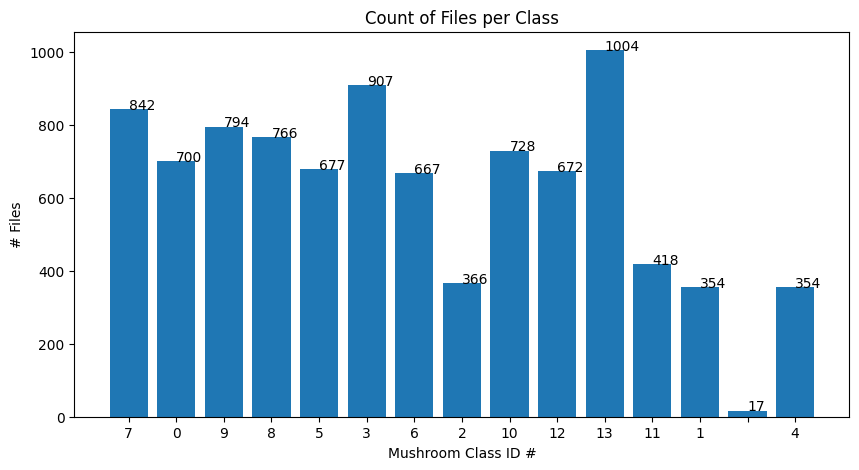

In [34]:
mushroom_class = list(file_class_dict.keys())
file_count = list(file_class_dict.values())

fig = plt.figure(figsize=(10, 5))
plt.bar(mushroom_class, file_count)
addlabels(mushroom_class, file_count)
plt.xlabel("Mushroom Class ID #")
plt.ylabel("# Files")
plt.title("Count of Files per Class")
plt.show()

Finding unaccounted for files (apparently they don't exist in the folder), when redistributing, these have to be filtered out as to not interfere with the program.

In [35]:
print(train_txt_files)
print(len(train_txt_files))

['../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/ah79_jpg.rf.718deb59740a508c8b3bf47c8c619135.txt', '../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/ah79_jpg.rf.8bef5aaa4f2489efeffe7b00b52f3480.txt', '../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/ah79_jpg.rf.1fe704539ec6476cf8ca253fc2e23e96.txt', '../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/aj127_jpg.rf.f6b1f1eadd2cca363fba7c830b20c270.txt', '../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/rr95_jpg.rf.e706a7ea431ef841f180497955ab7392.txt', '../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/6712medium_jpeg.rf.1ad0e685a333fc67b7e38535480002c9.txt', '../content/drive/MyDrive/IAT360/Mushrooms100.v16-dataset-14-types-2.yolov8/train/labels/6712medium_jpeg.rf.0d2a585c06f85619251c7a719dd05910.txt', '../

## Redistribution Plan

The graph above shows the total amount of text files per class (each text file corresponding to a single image). Unlike with the total amount of instances, it is clear that some classes have more images with multiple instances as such the cass with Amanita javanica (2).

In [36]:
def sort_files_by_class(holding_dict, directory_path):
    #assign the variables to the paths
    label_path_root = directory_path.replace('*', 'labels') + '/'
    # Seperate for easy changes
    label_path = label_path_root + '*'
    for item in glob.glob(label_path):
        label_file = os.path.basename(item)
        label_file_path = label_path_root + label_file
        mush_class = ''
        #find first class of each file
        with open(label_file_path, "r") as file:
            file_data = file.read().replace('\n', '')
            data = file_data.split(' ')
            mush_class = data[0]
            #skip files without real locations to prevent issues
            if mush_class == '':
                continue
        #Find equivalent image for text file
        file_name_root_list = label_file.split('.')
        file_name_root = '.'.join(file_name_root_list[0:-1])
        if mush_class not in holding_dict.keys():
            holding_dict[mush_class] = []
        holding_dict[mush_class].append(file_name_root)
    return holding_dict



In [37]:
mush_files_class_sort = {}

In [38]:
#for training set
mush_files_class_sort=sort_files_by_class(mush_files_class_sort, "data/Mushrooms100.v16-dataset-14-types-2.yolov8/train/*")
# for testing and validation
mush_files_class_sort=sort_files_by_class(mush_files_class_sort, "data/Mushrooms100.v16-dataset-14-types-2.yolov8/test/*")
mush_files_class_sort=sort_files_by_class(mush_files_class_sort, "data/Mushrooms100.v16-dataset-14-types-2.yolov8/valid/*")